In [13]:
from typing import Tuple, List
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from matplotlib import pyplot as plt
import random
import nltk
nltk.download('treebank')
from nltk.corpus import treebank
from collections import defaultdict
from eval_crf import concat_predictions, plot_confusion_matrix

import os

[nltk_data] Downloading package treebank to /home/quontas/nltk_data...
[nltk_data]   Package treebank is already up-to-date!


In [3]:
pos_tags = [
    tag for sentence in treebank.tagged_sents() 
    for _, tag in sentence
]
pos_tag_map = defaultdict(lambda: len(pos_tag_map))
for tag in pos_tags:
    pos_tag_map[tag]
print(pos_tag_map)

defaultdict(<function <lambda> at 0x7f37cb47d7b8>, {'NNP': 0, ',': 1, 'CD': 2, 'NNS': 3, 'JJ': 4, 'MD': 5, 'VB': 6, 'DT': 7, 'NN': 8, 'IN': 9, '.': 10, 'VBZ': 11, 'VBG': 12, 'CC': 13, 'VBD': 14, 'VBN': 15, '-NONE-': 16, 'RB': 17, 'TO': 18, 'PRP': 19, 'RBR': 20, 'WDT': 21, 'VBP': 22, 'RP': 23, 'PRP$': 24, 'JJS': 25, 'POS': 26, '``': 27, 'EX': 28, "''": 29, 'WP': 30, ':': 31, 'JJR': 32, 'WRB': 33, '$': 34, 'NNPS': 35, 'WP$': 36, '-LRB-': 37, '-RRB-': 38, 'PDT': 39, 'RBS': 40, 'FW': 41, 'UH': 42, 'SYM': 43, 'LS': 44, '#': 45})


In [4]:
TAG_MAP = {
    "OTHER": -1,
    "B-NAME": 0,
    "I-NAME": 1,
    "B-COMMENT": 2,
    "I-COMMENT": 3,
    "B-RANGE_END": 4,
    "B-UNIT": 5,
    "I-UNIT": 6,
    "B-QTY": 7,
}

REVERSE_MAP = {v: k for k, v in TAG_MAP.items()}


def parse_recipe(recipe: str) -> Tuple[List[str], List[int]]:
    """Given a CRF-tagged recipe string, converts it into a token/tag sequence.

    Args:
        recipe: A newline-delimited CRF recipe.
    Returns:
        A tuple of (tokens, tags) where tokens are List[str], and tags are List[int]
    """
    rows = recipe.split("\n")
    tokens = []
    tags = []
    for row in rows:
        if not row:
            continue
        token, _, _, _, _, tag = row.split("\t")
        tokens.append(token)
        tags.append(TAG_MAP[tag])
    return tokens, tags


def read_crf_file(filename):
    
    with open(filename) as f:
        lines = f.read()
        recipes = lines.split("\n\n")

        tokens = []
        tags = []
        for recipe in recipes:
            recipe_tokens, recipe_tags = parse_recipe(recipe)
            tokens.append(recipe_tokens)
            tags.append(recipe_tags)
        return tokens, tags

In [5]:
def get_feature(token, token_index, sent, pos_tags):
    """Extract features of given word(token)"""
    token_feature = {    
        'token'             : token,                                    # Token itself
        'is_first'          : token_index == 0,                         # Is token at the beginning of the sentence
        'is_last'           : token_index == len(sent)-1,               # Is token at the end of the sentence

        'is_capitalized'    : token[0].upper() == token[0],             # Is first letter of token a capital letter
        'is_all_capitalized': token.upper() == token,                   # Are all letters of token capital letters
        'is_capitals_inside': token[1:].lower() != token[1:],           # Is there any capital letters in the token
        'is_numeric'        : token.isdigit(),                          # Is there any digits in the token

        'prefix-1'          : token[0],                                 # Token prefix containing only one letter
        'prefix-2'          : '' if len(token) < 2  else token[:1],     # Token prefix containing two letters

        'suffix-1'          : token[-1],                                # Token suffix containing only one letter
        'suffix-2'          : '' if len(token) < 2  else token[-2:],    # Token suffix containing two letters

        'prev-token'        : '' if token_index == 0     else sent[token_index - 1][0],     # Previous token in the sentence
        '2-prev-token'      : '' if token_index <= 1     else sent[token_index - 2][0],     # Two previous token in the sentence

        'next-token'        : '' if token_index == len(sent) - 1     else sent[token_index + 1][0],     # Next token in the sentence
        '2-next-token'      : '' if token_index >= len(sent) - 2     else sent[token_index + 2][0],      # Two next token in the sentence
        'pos-tag'           : pos_tag_map[pos_tags[token_index]]
    }
    return token_feature

In [6]:
def construct_data(filename):
    tokens, tags = read_crf_file(filename)
    X = []
    y = []
    for token_list, tag_list in zip(tokens, tags):
        sentence_pos_tags = nltk.pos_tag(token_list)
        sentence = ' '.join(token_list)
        
        for i, token in enumerate(token_list):
            X.append(get_feature(token, i, sentence, sentence_pos_tags))
            y.append(tag_list[i])
    return X, y

In [7]:
X, y = construct_data('../data/train.crftags')
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3)

In [8]:
pipeline = make_pipeline(DictVectorizer(), LogisticRegression(class_weight='balanced'))

pipeline = pipeline.fit(X_train, y_train)

/home/quontas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/quontas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [9]:
y_predicted = pipeline.predict(X_valid)
print(f'Accuracy: {accuracy_score(y_valid, y_predicted)*100}%')

Accuracy: 72.2392963441173%


Accuracy: 73.66834170854271%
              precision    recall  f1-score   support

       OTHER       0.77      0.79      0.78       522
      B-NAME       0.69      0.62      0.65       400
      I-NAME       0.58      0.61      0.60       320
   B-COMMENT       0.64      0.74      0.69       562
   I-COMMENT       0.60      1.00      0.75         9
 B-RANGE_END       0.90      0.95      0.92       333
      B-UNIT       0.00      0.00      0.00         0
      I-UNIT       0.97      0.98      0.97       419
       B-QTY       0.64      0.45      0.53       420

   micro avg       0.74      0.74      0.74      2985
   macro avg       0.64      0.68      0.65      2985
weighted avg       0.74      0.74      0.73      2985
 samples avg       0.74      0.74      0.74      2985

Confusion matrix, without normalization
[[413  52  28  21   0   3   0   1   4]
 [ 67 248  16  48   1   3   1   0  16]
 [ 27   5 195  43   0   0   3   7  40]
 [ 14  37  38 415   2   6   4   0  46]
 [  0   0   0   

/home/quontas/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


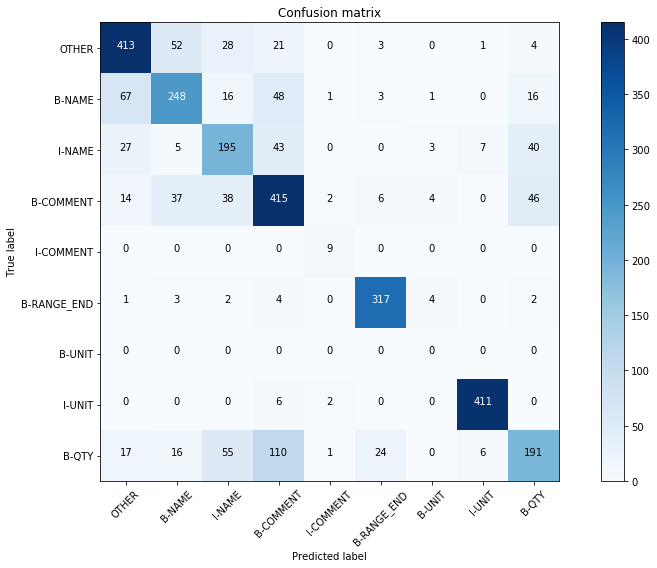

In [15]:
X_test, y_test = construct_data('../data/test.crftags')

y_test_predictions = pipeline.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_test_predictions)*100}%')
test_results = np.array(concat_predictions([y_test]))
test_pred_results = np.array(concat_predictions([y_test_predictions]))

print(classification_report(test_results, test_pred_results, target_names=TAG_MAP.keys()))

conf = confusion_matrix(test_results.argmax(axis=1), test_pred_results.argmax(axis=1))
plt.figure(figsize=(12,8))
plot_confusion_matrix(conf, classes=TAG_MAP.keys())
plt.show()